In [1]:
# load libraries
import numpy as np
import pandas as pd
import pickle as pkl
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import scipy.sparse as sp
import matplotlib.pyplot as plt
from tensorflow.compat.v1.nn.rnn_cell import RNNCell

import pickle as pkl
import math
import os
import numpy.linalg as la
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

Instructions for updating:
non-resource variables are not supported in the long term


### Build relation from wikidata

In [371]:
# Get wikidata id for companies
NASDAQ_wiki = pd.read_csv('NASDAQ_wiki.csv', header=None)
NYSE_wiki = pd.read_csv('NYSE_wiki.csv', header=None)
wiki = pd.concat([NASDAQ_wiki, NYSE_wiki])
list_tickers = [ticker for ticker in list(wiki[0]) if ticker in list(ticker_list)]
wiki_id = wiki[wiki[0].isin(list_tickers)]

list_tickers = [ticker for ticker in list(wiki[0]) if ticker in list(ticker_list)]
wiki_id = wiki[wiki[0].isin(list_tickers)]
temp = set(ticker_list)- set(wiki_id[0].tolist())
# pd.DataFrame(list(temp)).to_csv('temp.csv')

In [372]:
# Input wikidata tickers and id
wiki_id = pd.read_csv('wiki_id.csv')
wiki_id = wiki_id[['ticker', 'id']]

In [373]:
# Set up query to get data from https://query.wikidata.org
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def get_wiki_relation(wikiid, wiki_id):
    endpoint_url = "https://query.wikidata.org/sparql"
    query = """SELECT DISTINCT ?item ?itemLabel WHERE {
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
      {
        SELECT DISTINCT ?item WHERE {
          ?item p:P749 ?statement0.
          ?statement0 (ps:P749/(wdt:P279*)) wd:"""+wikiid+""".
        }
        LIMIT 100
      }
    }"""
    results = get_results(endpoint_url, query)
    try:
        results_df = pd.io.json.json_normalize(results['results']['bindings'])
        results_id = results_df['itemLabel.value'].tolist()

        relation_id = [ticker for ticker in results_id if ticker in list(wiki_id['id'])]
    except KeyError:
        relation_id = []
    return relation_id

In [374]:
relation_ids = {}
for wikiid in wiki_id['id'].dropna():
    relation_id = get_wiki_relation(wikiid, wiki_id)
    if len(relation_id)>0:
        relation_ids[wikiid] = relation_id
print(relation_ids)

/var/folders/93/plmmcsr91616wrj6rtn_wvgr0000gn/T/ipykernel_71531/2819447182.py:29: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  results_df = pd.io.json.json_normalize(results['results']['bindings'])


{'Q20800404': ['Q95'], 'Q7414': ['Q5476713']}


### Generate adj matrix

In [375]:
# Get ticker meta data
tickers_df = pd.read_csv('wikisp500.csv', index_col = False)
tickers_df = tickers_df[['Symbol', 'GICS Sector', 'GICS Sub-Industry']]
tickers_df.columns = ['symbol', 'sector', 'industry']

In [376]:
tickers_df.head()

,symbol,sector,industry
0,MMM,Industrials,Industrial Conglomerates
1,AOS,Industrials,Building Products
2,ABT,Health Care,Health Care Equipment
3,ABBV,Health Care,Pharmaceuticals
4,ABMD,Health Care,Health Care Equipment


In [410]:
num_nodes = len(tickers_df)
adjt = pd.DataFrame(np.zeros(shape=(num_nodes,num_nodes)))
adjt.columns=tickers_df['symbol'].unique()
adjt.index=tickers_df['symbol'].unique()

for ticker in tickers_df['symbol']:
    industry = tickers_df[tickers_df['symbol'] == ticker]['industry'].tolist()[0]
    for ticker2 in tickers_df[tickers_df['industry'] == industry]['symbol'].tolist():
        adjt.at[ticker, ticker2] = 1
# adjt.to_csv('adjt.csv')

### Generate Price Data

In [485]:
# Generate feature matrix
# Get price data from yahoo finance
# https://pypi.org/project/fix-yahoo-finance/0.1.30/
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
# Within last period < 60 days
ticker_list = tickers_df['symbol'].tolist()
data = pd.DataFrame()
for ticker in ticker_list:
    price = pdr.get_data_yahoo(ticker, start="2022-3-15", end="2022-4-15", interval="2m")
    price['ticker'] = ticker
    data = pd.concat([data, price])
data = data[['ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
data = data.reset_index()
data.head()
# price = data.loc[:, 'Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Datetime,ticker,Open,High,Low,Close,Adj Close,Volume
0,2022-03-15 09:30:00-04:00,MMM,144.869995,144.990005,144.559998,144.559998,144.559998,57744
1,2022-03-15 09:32:00-04:00,MMM,144.910004,144.945007,144.649994,144.729996,144.729996,32624
2,2022-03-15 09:34:00-04:00,MMM,144.764999,145.320007,144.764999,145.309998,145.309998,29254
3,2022-03-15 09:36:00-04:00,MMM,145.320007,145.380005,145.029999,145.300003,145.300003,21102
4,2022-03-15 09:38:00-04:00,MMM,145.229996,145.339996,145.065002,145.119995,145.119995,10308


In [486]:
print('Check missing data:', data.isnull().mean())
print('Data shahpe:', data.shape)
data[['Open', 'High', 'Low', 'Close', 'Adj Close']] = data[['Open', 'High', 'Low', 'Close', 'Adj Close']].pct_change()*100
data = data[1:]

Check missing data: Datetime     0.0
ticker       0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64
Data shahpe: (2134619, 8)


Totolly, we have 4485 time points and 502 tickers. Our feature columns are ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Datetime'], where ['Open', 'High', 'Low', 'Close', 'Adj Close'] means the return of ['Open', 'High', 'Low', 'Close', 'Adj Close'].

In [498]:
# The length of prediction is 5, which means 10 mins volatility.
pre_len = 5
seq_len = 5

In [499]:
# Calculate volatility using Adj Close
def realized_volatility(series_return):
    return np.sqrt(np.mean(series_return**2))

def realized_volatility_len(series_return, pre_len):
    vol = []
    length = len(series_return)
    for i in range(0,pre_len-1):
        vol.append(np.nan)
    for i in range(pre_len,length+1):
        vol.append(realized_volatility(series_return[i-pre_len:i]))
    return vol

for ticker in ticker_list:
    data_ticker = data.loc[data['ticker'] == ticker]
    data.loc[data['ticker'] == ticker, 'volatility'] = realized_volatility_len(data_ticker['Adj Close'], pre_len)

In [535]:
data['target'] = data['volatility']
for ticker in ticker_list:
    data_ticker = data.loc[data['ticker'] == ticker]
    data.loc[data['ticker'] == ticker, 'target'] = data_ticker["volatility"].shift(periods=-pre_len)
data = data.drop(['volatility'],axis=1)

In [536]:
data.head()

,Datetime,ticker,Open,High,Low,Close,Adj Close,Volume,target,volatility
1,2022-03-15 13:32:00,MMM,0.027617,-0.031035,0.062255,0.117597,0.117597,32624,0.306286,NaN
2,2022-03-15 13:34:00,MMM,-0.100065,0.258719,0.079506,0.400747,0.400747,29254,0.250309,NaN
3,2022-03-15 13:36:00,MMM,0.383385,0.041287,0.183055,-0.006878,-0.006878,21102,0.260250,NaN
4,2022-03-15 13:38:00,MMM,-0.061940,-0.027520,0.024135,-0.123887,-0.123887,10308,0.255642,NaN
5,2022-03-15 13:40:00,MMM,-0.037866,-0.096325,-0.120638,-0.158487,-0.158487,9150,0.247027,0.207336


In [554]:
print('Check missing data:', data.isnull().mean())

Check missing data: Datetime     0.000000
ticker       0.000000
Open         0.000000
High         0.000000
Low          0.000000
Close        0.000000
Adj Close    0.000000
Volume       0.000000
target       0.001176
dtype: float64


In [558]:
data.to_json('data.json')

In [ ]:
# returns = price.ffill().pct_change()[1:]*100
# returns.to_csv('returns.csv')

### Use KMeans Clustering to create relationship between companies based on correlation matrix

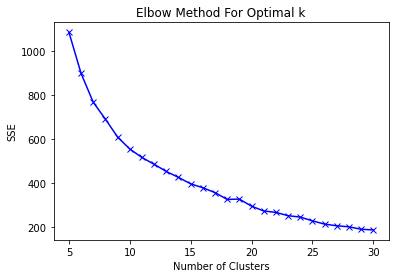

In [429]:
# Create relationship between companies based on correlation matrix
from sklearn.cluster import KMeans

corr = data.dropna().pivot(index='Datetime', columns='ticker', values='Close').corr()

# Determine the best value for k
def calculate_WSS(data):
    sse = []
    kmax = 30
    for k in range(5, kmax+1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        sse.append(kmeans.inertia_)
    plt.plot(range(5, kmax+1), sse, 'bx-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.title('Elbow Method For Optimal k')
    plt.show()    
    
calculate_WSS(corr.values)

According to the plot above, we set n_clusters = 18.

In [430]:
n_clusters = 18

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(corr.values)
# print(kmeans.labels_)
ids = corr.index
tickers_df_corr = pd.DataFrame({'ticker': ids.tolist(), 'cluster': kmeans.labels_.tolist()}, columns=['ticker', 'cluster'])

# Generate adj matrix    
num_nodes = len(tickers_df_corr)
adjt_corr = pd.DataFrame(np.zeros(shape=(num_nodes,num_nodes)))
adjt_corr.columns=tickers_df_corr['ticker'].unique()
adjt_corr.index=tickers_df_corr['ticker'].unique()

for ticker in tickers_df_corr['ticker']:
    cluster = tickers_df_corr[tickers_df_corr['ticker'] == ticker]['cluster'].tolist()[0]
    for ticker2 in tickers_df_corr[tickers_df_corr['cluster'] == cluster]['ticker'].tolist():
        adjt_corr.at[ticker, ticker2] = 1    

In [438]:
adj = adjt_corr.combine(adjt, np.maximum)
adj.to_csv('adj.csv')

### Input data

In [391]:
# Load adj and feautes matrix
def load_data():
#     adj = pd.read_csv(r'adjt.csv')
#     adj = adj.set_index('Unnamed: 0')
    adj = pd.read_csv('adj.csv', index_col=0)
    adj = np.mat(adj)
    frs = pd.read_csv(r'returns.csv')
    frs = frs.set_index('Datetime')
    frs = frs.fillna(0)
    return adj, frs

In [392]:
adj, frs = load_data()

### Plot the graph

In [445]:
import networkx as nx

adj = pd.read_csv('adj.csv', index_col=0)
# Create an edge list dataframe from a adjacency matrix in Python?
G = nx.from_pandas_adjacency(adj, create_using=nx.MultiDiGraph())
df = nx.to_pandas_edgelist(G)[['source', 'target']]
df = df[df['source'] != df['target']]
print('Edge list shape:', df.shape)

Edge list shape: (47832, 2)


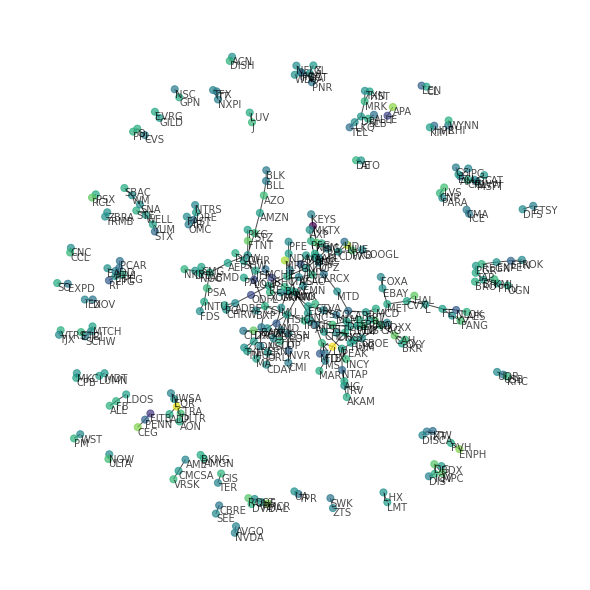

In [446]:
import networkx as nx

plt.figure(figsize=(8, 8))
df1 = df.sample(n=250)
df_graph = nx.from_pandas_edgelist(df1, 'source', 'target')
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx
nx.draw_spring(df_graph, node_size=50, node_color=frs.mean()[list(df_graph.nodes)].tolist(), font_size = 10, with_labels=True, alpha=0.7, horizontalalignment='left', verticalalignment='top')


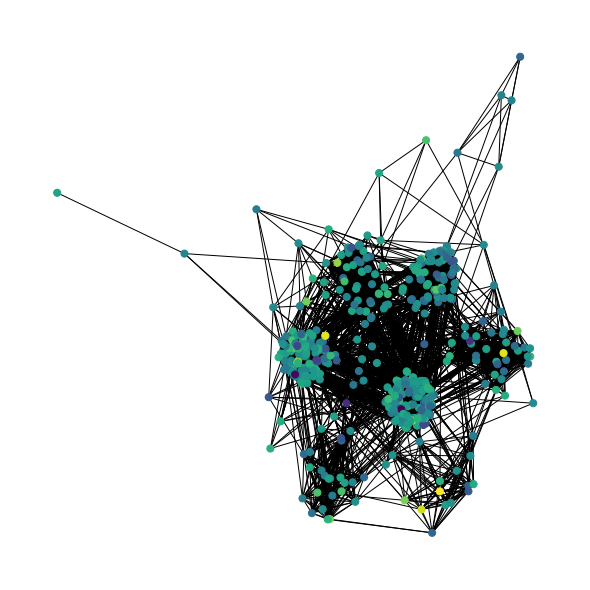

In [455]:
plt.figure(figsize=(8, 8))
df1 = df
df_graph = nx.from_pandas_edgelist(df1, 'source', 'target')
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx
nx.draw_spring(df_graph, node_size=50, node_color=frs.mean()[list(df_graph.nodes)].tolist())

# Baseline Model

### Data Process

In [629]:
# Parameters
pre_len = 5
k_flod = 5

In [559]:
# Import data
data = pd.read_json('data.json')
data.shape

(2134618, 9)

In [630]:
data.head()

,Datetime,ticker,Open,High,Low,Close,Adj Close,Volume,target
1,2022-03-15 13:32:00,MMM,0.027617,-0.031035,0.062255,0.117597,0.117597,32624,0.306286
2,2022-03-15 13:34:00,MMM,-0.100065,0.258719,0.079506,0.400747,0.400747,29254,0.250309
3,2022-03-15 13:36:00,MMM,0.383385,0.041287,0.183055,-0.006878,-0.006878,21102,0.260250
4,2022-03-15 13:38:00,MMM,-0.061940,-0.027520,0.024135,-0.123887,-0.123887,10308,0.255642
5,2022-03-15 13:40:00,MMM,-0.037866,-0.096325,-0.120638,-0.158487,-0.158487,9150,0.247027


In [667]:
# Data process
data = data.dropna()
data = data.loc[data['target']!=0.0]
data = data.reset_index(drop=True)

In [607]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

### Multiple Linear Regression

In [636]:
from sklearn.linear_model import LinearRegression

def process_data_lr(data):
    temp = data.dropna().drop(['Datetime', 'Adj Close', 'ticker'], axis=1)
    y = temp['target']
    X = pd.get_dummies(data=temp)
    X = X.drop(['target'], axis=1)
    return X, y

RMSE of the linear regression model is  1.4533415932362663 .


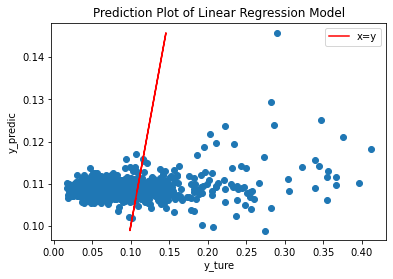

In [654]:
X, y = process_data_lr(data)

model = LinearRegression()
model.fit(X,y)
pred = model.predict(X)
print('RMSE of the linear regression model is ', rmspe(y, pred), '.')
plt.plot(y[:1000], pred[:1000], 'o')
plt.plot(pred[:1000], pred[:1000], color = 'red', label = 'x=y')
plt.xlabel('y_ture')
plt.ylabel('y_predict')
plt.title('Prediction Plot of Linear Regression Model')
plt.legend()

### LightGBM

In [655]:
# # Group by the stock id
# vol_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
# ticker_id = data.groupby(['ticker'])[vol_cols].agg(['mean', 'std', 'max', 'min']).reset_index()
# ticker_id.columns = ['_'.join(col) for col in ticker_id.columns]
# ticker_id

# # Group by the time id
# time_id = data.groupby(['Datetime'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
# # Rename columns joining suffix
# time_id.columns = ['_'.join(col) for col in time_id.columns]
# time_id = time_id.add_suffix('_' + 'time')
# time_id

In [656]:
def process_data_LightGBM(data):
    # https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
    data1 = data.copy()
    data1['ticker'] = data1['ticker'].astype('category').cat.codes
    data1['Datetime'] = data1['Datetime'].astype('category').cat.codes
    
    X = data1.dropna().drop(['Adj Close', 'target'], axis=1)
    y = data['target']
    return X, y

In [676]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Booster.html#lightgbm.Booster.feature_importance
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(6, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

# https://www.kaggle.com/code/tommy1028/lightgbm-starter-with-feature-engineering-idea
import lightgbm as lgbm

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

In [668]:
params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

# Cross Validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=k_flod, random_state=0, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

X, y = process_data_LightGBM(data)
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold :", fold+1)    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=1000,         
                      feval=feval_RMSPE,
                      verbose_eval=100,
                      categorical_feature = ['ticker', 'Datetime']                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / k_flod
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---  
    feature_names = X_train.columns.values.tolist()
    gain_importance_df = calc_model_importance(
        model, feature_names=feature_names, importance_type='gain')
    gain_importance_list.append(gain_importance_df)

    split_importance_df = calc_model_importance(
        model, feature_names=feature_names, importance_type='split')
    split_importance_list.append(split_importance_df)

Fold : 1


/Users/xinyue/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Datetime', 'ticker']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/xinyue/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6173
[LightGBM] [Info] Number of data points in the train set: 1705619, number of used features: 7


/Users/xinyue/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/xinyue/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 0.039596
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.0272746	training's RMSPE: 0.51692	valid_1's rmse: 0.0282319	valid_1's RMSPE: 0.52129
[200]	training's rmse: 0.025004	training's RMSPE: 0.47389	valid_1's rmse: 0.0262752	valid_1's RMSPE: 0.48516
[300]	training's rmse: 0.0240081	training's RMSPE: 0.45501	valid_1's rmse: 0.0254614	valid_1's RMSPE: 0.47013
[400]	training's rmse: 0.0234426	training's RMSPE: 0.4443	valid_1's rmse: 0.0250337	valid_1's RMSPE: 0.46223
[500]	training's rmse: 0.0230494	training's RMSPE: 0.43684	valid_1's rmse: 0.0247529	valid_1's RMSPE: 0.45705
[600]	training's rmse: 0.0227909	training's RMSPE: 0.43194	valid_1's rmse: 0.024592	valid_1's RMSPE: 0.45408
[700]	training's rmse: 0.022595	training's RMSPE: 0.42823	valid_1's rmse: 0.0244975	valid_1's RMSPE: 0.45233
[800]	training's rmse: 0.0224319	training's RMSPE: 0.42514	valid_1's rmse: 0.0244289	valid_1's RMSPE: 0.45107
[900]	trai

[1000]	training's rmse: 0.0225911	training's RMSPE: 0.41932	valid_1's rmse: 0.0227155	valid_1's RMSPE: 0.45412
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0225911	training's RMSPE: 0.41932	valid_1's rmse: 0.0227155	valid_1's RMSPE: 0.45412
Performance of the　prediction: , RMSPE: 0.454
****************************************************************************************************


Average RMSE of the LightGBM model is 0.462 .


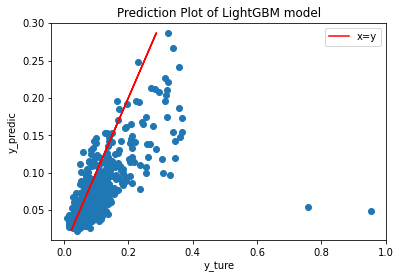

In [672]:
print('Average RMSE of the LightGBM model is', round(scores,5), '.')
plt.plot(y_valid[:1000], y_pred[:1000], 'o')
plt.plot(y_pred[:1000], y_pred[:1000], color = 'red', label = 'x=y')
plt.xlabel('y_ture')
plt.ylabel('y_predict')
plt.title('Prediction Plot of LightGBM model')
plt.legend()

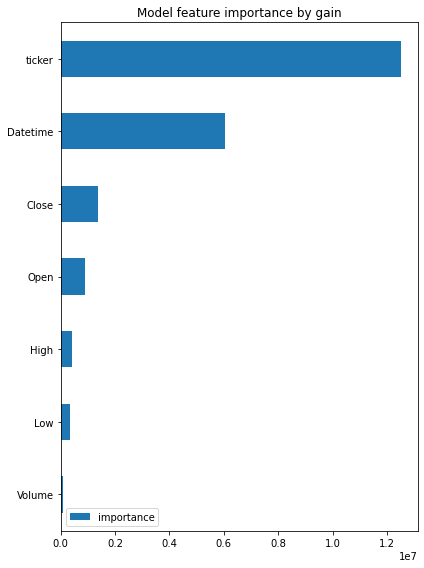

In [677]:
mean_gain_df = calc_mean_importance(gain_importance_list)
plot_importance(mean_gain_df, title='Model feature importance by gain')
mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
# mean_gain_df.to_csv('gain_importance_mean.csv', index=False)

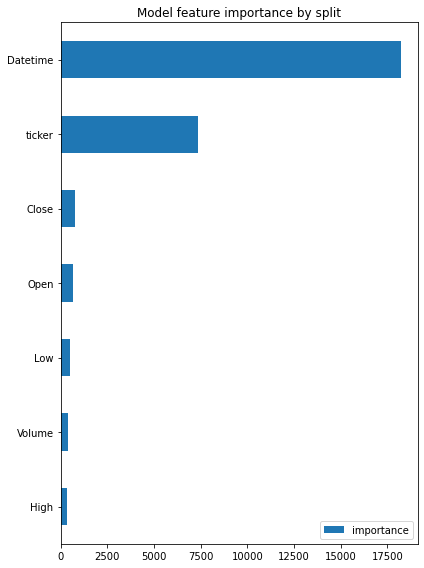

In [678]:
mean_split_df = calc_mean_importance(split_importance_list)
plot_importance(mean_split_df, title='Model feature importance by split')
mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
# mean_split_df.to_csv('split_importance_mean.csv', index=False)

### NN Model

In [682]:
# ref https://www.kaggle.com/code/alexioslyon/lgbm-baseline
def process_data_nn(data):
    # https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
    data1 = data.copy()
    data1['ticker'] = data1['ticker'].astype('category').cat.codes
    data1['Datetime'] = data1['Datetime'].astype('category').cat.codes
    
    X = data1.dropna().drop(['target'], axis=1)
    y = data['target']
    return X, y

In [684]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from keras import backend as K

# Define activation function
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
get_custom_objects().update({'swish': Activation(swish)})

def root_mean_squared_per_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')

hidden_units = (128,64,32)
ticker_embedding_size = 12

def nn_model():    
    ticker_input = keras.Input(shape=(1,), name='ticker')
    num_input = keras.Input(shape=(7,), name='num_data')

    #embedding, flatenning and concatenating
    ticker_embedded = keras.layers.Embedding(len(set(cat_data)), ticker_embedding_size, 
                                           input_length=1, name='ticker_embedding')(ticker_input)
    ticker_flattened = keras.layers.Flatten()(ticker_embedded)
    output = keras.layers.Concatenate()([ticker_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:
        output = keras.layers.Dense(n_hidden, activation='swish')(output)
        
    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    output = keras.layers.Dense(1, activation='linear', name='prediction')(output)
    
    model = keras.Model(
        inputs = [ticker_input, num_input],
        outputs = output,
    )
    
    return model

In [696]:
target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

kf = KFold(n_splits=k_flod, shuffle=True, random_state=2020)
X, y = process_data_nn(data)
scores_folds[model_name] = []

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold :", fold+1)    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]   
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.006),
        loss=root_mean_squared_per_error
    )
    
    
    num_data = X_train[['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]    
    cat_data = X_train['ticker']
    target =  y_train
    
    num_data_valid = X_valid[['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]    
    cat_data_valid = X_valid['ticker']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=100,
              validation_data=([cat_data_valid, num_data_valid], y_valid),
              callbacks=[es, plateau],
#               validation_batch_size=len(y_valid),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_valid, num_data_valid]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_valid, y_pred = preds),5)
    print('Fold {} {} RMSE: {}'.format(fold+1, model_name, score))
    scores_folds[model_name].append(score)

Fold : 1
Train on 1705619 samples, validate on 426405 samples
Epoch 1/10
1705619/1705619 [==============================] - 8s 5us/sample - loss: 964.3750 - val_loss: 3.1321 - lr: 0.0060
Epoch 2/10
1705619/1705619 [==============================] - 6s 4us/sample - loss: 1.2582 - val_loss: 0.8941 - lr: 0.0060
Epoch 3/10
1705619/1705619 [==============================] - 6s 4us/sample - loss: 0.9586 - val_loss: 0.6659 - lr: 0.0060
Epoch 4/10
1705619/1705619 [==============================] - 6s 4us/sample - loss: 0.6753 - val_loss: 0.6496 - lr: 0.0060
Epoch 5/10
1705619/1705619 [==============================] - 6s 4us/sample - loss: 0.6519 - val_loss: 0.6466 - lr: 0.0060
Epoch 6/10
1705619/1705619 [==============================] - 6s 4us/sample - loss: 0.6515 - val_loss: 0.6412 - lr: 0.0060
Epoch 7/10
1705619/1705619 [==============================] - 7s 4us/sample - loss: 0.6487 - val_loss: 0.6614 - lr: 0.0060
Epoch 8/10
1705619/1705619 [==============================] - 7s 4us/sample

In [762]:
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ticker (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
ticker_embedding (Embedding)    (None, 1, 12)        6024        ticker[0][0]                     
__________________________________________________________________________________________________
flatten_29 (Flatten)            (None, 12)           0           ticker_embedding[0][0]           
__________________________________________________________________________________________________
num_data (InputLayer)           [(None, 7)]          0                                            
___________________________________________________________________________________________

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Average RMSE of the Neural Network model is 0.65944 .


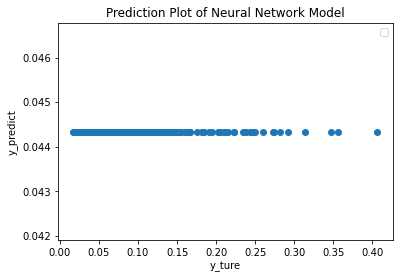

In [715]:
print('Average RMSE of the Neural Network model is', round(sum(scores_folds[model_name])/len(scores_folds[model_name]),5), '.')
plt.plot(y_valid[:500], preds[:500], 'o')
# plt.plot(pred[:500], pred[:500], color = 'red', label = 'x=y')
plt.xlabel('y_ture')
plt.ylabel('y_predict')
plt.title('Prediction Plot of Neural Network Model')
plt.legend()

### GNN

In [909]:
import scipy

In [962]:
features = data[['ticker', 'target', 'Datetime']].reset_index().pivot(index='ticker', columns='Datetime', values='target')
labels = np.array(features[features.columns[-2]])
features = features[features.columns[-7:-2]]
features = scipy.sparse.csr_matrix(features).todense()
adj_gnn = scipy.sparse.csr_matrix(adj).todense()
features = features.astype('float32')
adj_gnn = adj_gnn.astype('float32')


In [963]:
def gnn(fts, adj, transform, activation):
    seq_fts = transform(fts)
    ret_fts = tf.matmul(adj.astype('float32'), seq_fts)
    return activation(ret_fts)

In [964]:
def train_cora(fts, adj, gnn_fn, units, epochs, lr):
    lyr_1 = tf.keras.layers.Dense(units)
    lyr_2 = tf.keras.layers.Dense(units)
    lyr_3 = keras.layers.Dense(1)
    
    def cora_gnn(fts, adj):
        hidden = gnn_fn(fts, adj, lyr_1, tf.nn.relu)
        hidden = gnn_fn(hidden, adj, lyr_2, tf.nn.relu)
        logits = gnn_fn(hidden, adj, lyr_3, tf.identity)
        return logits
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    
    best_score = tf.constant(0.0)
    for ep in range(epochs + 1):
        with tf.GradientTape() as t:
            logits = cora_gnn(fts, adj)
            loss = tf.keras.metrics.mean_squared_error(y_pred = logits, y_true = labels)
        
        variables = t.watched_variables()
        grads = t.gradient(loss, variables)
        optimizer.apply_gradients(zip(grads, variables))
        
        logits = cora_gnn(fts, adj)
        score = tf.keras.metrics.mean_squared_error(y_pred = logits, y_true = labels)
#         score = round(rmspe(y_true = labels, y_pred = logits),5)
        
        def f1(): return score
        def f2(): return bestscore
        best_score = tf.cond(tf.less(best_score, score), f1, f2)
        print('Epoch', ep, '| Training loss:', loss.numpy(), '| RMSE:',score.numpy())

In [966]:
train_cora(features, adj_gnn, gnn, 32, 100, 0.01)

## Build a TGN model

In [3]:
# Divide data into training, test, and validation dataset
# preprocess_data(data1, time_len=data.shape[0], train_rate=0.8, seq_len=195, pre_len=15)
def load_data():
    adj = pd.read_csv(r'adjt.csv')
    adj = adj.set_index('Unnamed: 0')
#     adj = pd.read_csv('adj.csv', index_col=0)
    adj = np.mat(adj)
    frs = pd.read_csv(r'returns.csv')
    frs = frs.set_index('Datetime')
    frs = frs.fillna(0)
    return adj, frs

def preprocess_data(data, time_len, train_rate, seq_len, pre_len):
    train_size = int(time_len * train_rate)
    train_data = data[0:train_size]
    test_data = data[train_size:time_len]
    
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len):
        a = train_data[i: i + seq_len + pre_len]
        trainX.append(a[0 : seq_len])
        trainY.append(a[seq_len : seq_len + pre_len])
    for i in range(len(test_data) - seq_len -pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0 : seq_len])
        testY.append(b[seq_len : seq_len + pre_len])
      
    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)
    return trainX, trainY, testX, testY
    
    
## utils
def normalized_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    normalized_adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    normalized_adj = normalized_adj.astype(np.float32)
    return normalized_adj
    
def sparse_to_tuple(mx):
    mx = mx.tocoo()
    coords = np.vstack((mx.row, mx.col)).transpose()
    L = tf.SparseTensor(coords, mx.data, mx.shape)
    return tf.sparse_reorder(L) 
    
def calculate_laplacian(adj, lambda_max=1):  
    adj = normalized_adj(adj + sp.eye(adj.shape[0]))
    adj = sp.csr_matrix(adj) # Construct an matrix
    adj = adj.astype(np.float32) 
    return sparse_to_tuple(adj)
   
def weight_variable_glorot(input_dim, output_dim, name=""):
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.random_uniform([input_dim, output_dim], minval=-init_range,
                            maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial,name=name)  

In [4]:
# Visualization
def plot_result(test_result,test_label1,path):
    ##all test result visualization
    fig1 = plt.figure(figsize=(7,1.5))
#    ax1 = fig1.add_subplot(1,1,1)
    a_pred = test_result[:,0]
    a_true = test_label1[:,0]
    plt.plot(a_pred,'r-',label='prediction')
    plt.plot(a_true,'b-',label='true')
    plt.legend(loc='best',fontsize=10)
#     plt.savefig(path+'/test_all.jpg')
    plt.show()
    
    ## oneday test result visualization
    fig1 = plt.figure(figsize=(7,1.5))
#    ax1 = fig1.add_subplot(1,1,1)
    a_pred = test_result[0:96,0]
    a_true = test_label1[0:96,0]
    plt.plot(a_pred,'r-',label="prediction")
    plt.plot(a_true,'b-',label="true")
    plt.legend(loc='best',fontsize=10)
#     plt.savefig(path+'/test_oneday.jpg')
    plt.show()
    
def plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path):
    ###train_rmse & test_rmse 
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(train_rmse, 'r-', label="train_rmse")
    plt.plot(test_rmse, 'b-', label="test_rmse")
    plt.legend(loc='best',fontsize=10)
#     plt.savefig(path+'/rmse.jpg')
    plt.show()
    
    #### train_loss & train_rmse
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(train_loss,'b-', label='train_loss')
    plt.legend(loc='best',fontsize=10)
#     plt.savefig(path+'/train_loss.jpg')
    plt.show()

    fig1 = plt.figure(figsize=(5,3))
    plt.plot(train_rmse,'b-', label='train_rmse')
    plt.legend(loc='best',fontsize=10)
#     plt.savefig(path+'/train_rmse.jpg')
    plt.show()

    ### accuracy
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(test_acc, 'b-', label="test_acc")
    plt.legend(loc='best',fontsize=10)
#     plt.savefig(path+'/test_acc.jpg')
    plt.show()
    ### rmse
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(test_rmse, 'b-', label="test_rmse")
    plt.legend(loc='best',fontsize=10)
#     plt.savefig(path+'/test_rmse.jpg')
    plt.show()
    ### mae
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(test_mae, 'b-', label="test_mae")
    plt.legend(loc='best',fontsize=10)
#     plt.savefig(path+'/test_mae.jpg')
    plt.show()

In [5]:
# Set up parameters
time_start = time.time()
###### Settings ######
flags = tf.app.flags
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('training_epoch', 5, 'Number of epochs to train.')
flags.DEFINE_integer('gru_units', 128, 'hidden units of gru.')
flags.DEFINE_integer('seq_len',30, '  time length of inputs.')
flags.DEFINE_integer('pre_len', 5, 'time length of prediction.')
flags.DEFINE_float('train_rate', 0.8, 'rate of training set.')
flags.DEFINE_integer('batch_size', 32, 'batch size.')
# flags.DEFINE_string('dataset', 'los', 'sz or los.')
flags.DEFINE_string('model_name', 'tgcn', 'tgcn')
model_name = FLAGS.model_name
# data_name = FLAGS.dataset
train_rate =  FLAGS.train_rate
seq_len = FLAGS.seq_len
output_dim = pre_len = FLAGS.pre_len
batch_size = FLAGS.batch_size
lr = FLAGS.learning_rate
training_epoch = FLAGS.training_epoch
gru_units = FLAGS.gru_units

In [6]:
###### load data ######
adj, data = load_data()

time_len = data.shape[0]
num_nodes = data.shape[1]
# data1 =np.mat(data, dtype=np.float32)
data1 = np.asmatrix(data.values)

#### normalization
# max_value = np.max(data1) # Get the max number of the feature matrix
# data1  = data1/max_value # Make sure all data in (0,1)
trainX, trainY, testX, testY = preprocess_data(data1, time_len, train_rate, seq_len, pre_len) #Get training and test data

totalbatch = int(trainX.shape[0]/batch_size) # Batches
training_data_count = len(trainX)

In [7]:
# tgcn model
# tf.compat.v1.nn.rnn_cell.RNNCell(
#     trainable=True, name=None, dtype=None, **kwargs
# )
# (output, next_state) = call(input, state)
class tgcnCell(RNNCell):
    """Temporal Graph Convolutional Network """

    def call(self, inputs, **kwargs):
        pass

    def __init__(self, num_units, adj, num_nodes, input_size=None,
                 act=tf.nn.tanh, reuse=None):

        super(tgcnCell, self).__init__(_reuse=reuse)
        self._act = act
        self._nodes = num_nodes
        self._units = num_units
        self._adj = []
        self._adj.append(calculate_laplacian(adj))


    @property
    def state_size(self):
        return self._nodes * self._units

    @property
    def output_size(self):
        return self._units

    def __call__(self, inputs, state, scope=None):

        with tf.variable_scope(scope or "tgcn"):
            with tf.variable_scope("gates"):  
                value = tf.nn.sigmoid(
                    self._gc(inputs, state, 2 * self._units, bias=1.0, scope=scope))
                r, u = tf.split(value=value, num_or_size_splits=2, axis=1)
            with tf.variable_scope("candidate"):
                r_state = r * state
                c = self._act(self._gc(inputs, r_state, self._units, scope=scope))
            new_h = u * state + (1 - u) * c
        return new_h, new_h


    def _gc(self, inputs, state, output_size, bias=0.0, scope=None):
        ## inputs:(-1,num_nodes)
        inputs = tf.expand_dims(inputs, 2)
        ## state:(batch,num_node,gru_units)
        state = tf.reshape(state, (-1, self._nodes, self._units))
        ## concat
        x_s = tf.concat([inputs, state], axis=2)
        input_size = x_s.get_shape()[2].value
        ## (num_node,input_size,-1)
        x0 = tf.transpose(x_s, perm=[1, 2, 0])  
        x0 = tf.reshape(x0, shape=[self._nodes, -1])
        
        scope = tf.get_variable_scope()
        with tf.variable_scope(scope):
            for m in self._adj:
                x1 = tf.sparse_tensor_dense_matmul(m, x0)
#                print(x1)
            x = tf.reshape(x1, shape=[self._nodes, input_size,-1])
            x = tf.transpose(x,perm=[2,0,1])
            x = tf.reshape(x, shape=[-1, input_size])
            weights = tf.get_variable(
                'weights', [input_size, output_size], initializer= tf.compat.v1.keras.initializers.glorot_normal()) #tf.contrib.layers.xavier_initializer())
            x = tf.matmul(x, weights)  # (batch_size * self._nodes, output_size)
            biases = tf.get_variable(
                "biases", [output_size], initializer=tf.constant_initializer(bias, dtype=tf.float32))
            x = tf.nn.bias_add(x, biases)
            x = tf.reshape(x, shape=[-1, self._nodes, output_size])
            x = tf.reshape(x, shape=[-1, self._nodes * output_size])
        return x


In [8]:
def TGCN(_X, _weights, _biases):
    ###
    cell_1 = tgcnCell(gru_units, adj, num_nodes=num_nodes) # tgcnCell(num_units, adj, num_nodes)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell_1], state_is_tuple=True) #RNN cell composed sequentially of multiple simple cells.
    _X = tf.unstack(_X, axis=1)
    outputs, states = tf.nn.static_rnn(cell, _X, dtype=tf.float32)
    m = []
    for i in outputs:
        o = tf.reshape(i,shape=[-1,num_nodes,gru_units])
        o = tf.reshape(o,shape=[-1,gru_units])
        m.append(o)
    last_output = m[-1]
    output = tf.matmul(last_output, _weights['out']) + _biases['out']
    output = tf.reshape(output,shape=[-1,num_nodes,pre_len])
    output = tf.transpose(output, perm=[0,2,1])
    output = tf.reshape(output, shape=[-1,num_nodes])
    return output, m, states

In [9]:
###### placeholders ######
inputs = tf.placeholder(tf.float32, shape=[None, seq_len, num_nodes])
labels = tf.placeholder(tf.float32, shape=[None, pre_len, num_nodes])

# Graph weights
weights = {
    'out': tf.Variable(tf.random_normal([gru_units, pre_len], mean=1.0), name='weight_o')}
biases = {
    'out': tf.Variable(tf.random_normal([pre_len]),name='bias_o')}

if model_name == 'tgcn':
    pred,ttts,ttto = TGCN(inputs, weights, biases)

y_pred = pred

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
###### optimizer ######
lambda_loss = 0.001 #0.0015
Lreg = lambda_loss * sum(tf.nn.l2_loss(tf.cast(tf_var, tf.float32)) for tf_var in tf.trainable_variables())
label = tf.reshape(labels, [-1,num_nodes])
##loss
loss = tf.reduce_mean(tf.nn.l2_loss(y_pred-label) + Lreg)
##rmse
error = tf.sqrt(tf.reduce_mean(tf.square(y_pred-label)))
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

###### Initialize session ######
variables = tf.global_variables()
saver = tf.train.Saver(tf.global_variables())  
#sess = tf.Session()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

# Define output file name
out = 'out/%s'%(model_name)
#out = 'out/%s_%s'%(model_name,'perturbation')
path1 = '%s_%s_lr%r_batch%r_unit%r_seq%r_pre%r_epoch'%(model_name,lr,batch_size,gru_units,seq_len,pre_len,training_epoch)
path = os.path.join(out,path1)
if not os.path.exists(path):
    os.makedirs(path)
    

In [13]:
###### evaluation ######
def evaluation(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    F_norm = la.norm(a-b)/la.norm(a) #fro
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    return rmse, mae, F_norm, r2, var

In [15]:
x_axe,batch_loss,batch_rmse,batch_pred = [], [], [], []
test_loss,test_rmse,test_mae,test_acc,test_r2,test_var,test_pred = [],[],[],[],[],[],[]
  
for epoch in range(training_epoch):
    for m in range(totalbatch):
        mini_batch = trainX[m * batch_size : (m+1) * batch_size]
        mini_label = trainY[m * batch_size : (m+1) * batch_size]
        _, loss1, rmse1, train_output = sess.run([optimizer, loss, error, y_pred],
                                                 feed_dict = {inputs:mini_batch, labels:mini_label})
        batch_loss.append(loss1)
        batch_rmse.append(rmse1) 

     # Test completely at every epoch
    loss2, rmse2, test_output = sess.run([loss, error, y_pred],
                                         feed_dict = {inputs:testX, labels:testY}) #Output loss2. Use the whole test dataset
    test_label = np.reshape(testY,[-1,num_nodes])
    rmse, mae, acc, r2_score, var_score = evaluation(test_label, test_output) #Output rmse, acc
    test_label1 = test_label 
    test_output1 = test_output 
    test_loss.append(loss2)
    test_rmse.append(rmse) 
    test_mae.append(mae) 
    test_acc.append(acc)
    test_r2.append(r2_score)
    test_var.append(var_score)
    test_pred.append(test_output1)
    
    print('Iter:{}'.format(epoch),
          'train_rmse:{:.4}'.format(batch_rmse[-1]),
          'test_loss:{:.4}'.format(loss2),
          'test_rmse:{:.4}'.format(rmse),
          'test_F_norm:{:.4}'.format(acc))
    
    if (epoch % 500 == 0):        
        saver.save(sess, path+'/model_100/TGCN_pre_%r'%epoch, global_step = epoch)
        
time_end = time.time()
print('Time spent:', time_end-time_start,'s')

In [ ]:
print('RMSE of the TGCN model is', round(rmse2,5), '.')
plt.plot(testY[:500], y_pred[:500], 'o')
# plt.plot(y_pred[:500], y_pred[:500], color = 'red', label = 'x=y')
plt.xlabel('y_ture')
plt.ylabel('y_predict')
plt.title('Prediction Plot of Temporal Graph Neural Network Model')
plt.legend()

In [ ]:
############## visualization ###############
b = int(len(batch_rmse)/totalbatch)
batch_rmse1 = [i for i in batch_rmse]
train_rmse = [(sum(batch_rmse1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]
batch_loss1 = [i for i in batch_loss]
train_loss = [(sum(batch_loss1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]

index = test_rmse.index(np.min(test_rmse))
test_result = test_pred[index]
var = pd.DataFrame(test_result)
var.to_csv('test_result.csv',index = False,header = False)
plot_result(test_result,test_label1,path) #Only one epoch here
plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path)

print('min_rmse:%r'%(np.min(test_rmse)),
      'min_mae:%r'%(test_mae[index]),
      'F_norm:%r'%(test_acc[index]),
      'r2:%r'%(test_r2[index]),
      'var:%r'%test_var[index])